In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

In [2]:
import matplotlib.pyplot as plt
plt.rc("axes", titlesize=18, titleweight="bold")
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", autolayout=True)

import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [3]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
sample_submission = pd.read_csv("sample_submission.csv", index_col=0)

train.head()

,safe_text,label,agreement
tweet_id,,,
CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


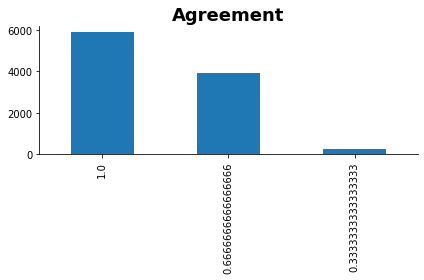

In [4]:
train["agreement"].value_counts().plot.bar(title="Agreement")

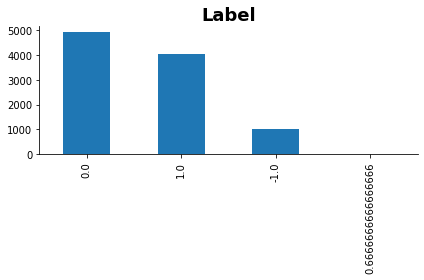

In [5]:
train["label"].value_counts().plot.bar(title="Label")

In [6]:
BATCH_SIZE = 128
EPOCHS = 30


data = train.query("agreement > 0.6 and label in [-1.0, 1.0, 0]")

# Remove HTML tags
X = (
        data["safe_text"].str.lower()
        .str.replace(
            pat='<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});',
            repl=" ",
            case=False,
            regex=True
        )
)
y = data["label"]

X.head()

tweet_id
CL1KWCMY    me   the big homie meanboy3000 #meanboy #mb #m...
E3303EME    i'm 100% thinking of devoting my career to pro...
M4IVFSMS    #whatcausesautism vaccines, do not vaccinate y...
1DR6ROZ4    i mean if they immunize my kid with something ...
J77ENIIE    thanks to   catch me performing at la nuit nyc...
Name: safe_text, dtype: object

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=3)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)
).batch(BATCH_SIZE)

valid_dataset = tf.data.Dataset.from_tensor_slices(
    (X_valid, y_valid)
).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    test["safe_text"].fillna("")
).batch(BATCH_SIZE)

In [8]:
bert_model_name = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2"
bert_model_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessing_layer = hub.KerasLayer(bert_model_preprocess)
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model_name, trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1, activation="tanh")(net)
    return tf.keras.Model(text_input, net)


model = build_classifier_model()

In [9]:
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model.compile(
    optimizer=optimizer,
    loss="mse"
)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-4, patience=3, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
)

Epoch 1/30
58/58 [==============================] - 87s 1s/step - loss: 0.7901 - val_loss: 0.4430
Epoch 2/30
58/58 [==============================] - 81s 1s/step - loss: 0.5045 - val_loss: 0.3721
Epoch 3/30
58/58 [==============================] - 81s 1s/step - loss: 0.4567 - val_loss: 0.3703
Epoch 4/30
58/58 [==============================] - 80s 1s/step - loss: 0.4156 - val_loss: 0.3349
Epoch 5/30
58/58 [==============================] - 81s 1s/step - loss: 0.3793 - val_loss: 0.3440
Epoch 6/30
58/58 [==============================] - 81s 1s/step - loss: 0.3604 - val_loss: 0.3198
Epoch 7/30
58/58 [==============================] - 81s 1s/step - loss: 0.3409 - val_loss: 0.3125
Epoch 8/30
58/58 [==============================] - 81s 1s/step - loss: 0.3300 - val_loss: 0.3211
Epoch 9/30
58/58 [==============================] - 81s 1s/step - loss: 0.3140 - val_loss: 0.3127
Epoch 10/30
58/58 [==============================] - 81s 1s/step - loss: 0.2995 - val_loss: 0.3120
Epoch 11/30
58/58 [

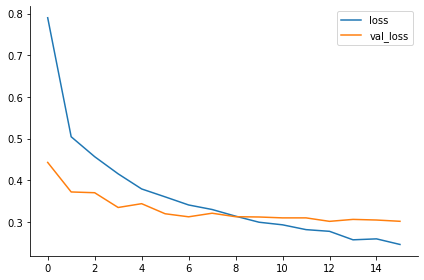

In [11]:
pd.DataFrame(history.history).plot()

In [12]:
sample_submission["label"] = model.predict(test_dataset)
sample_submission.head()

,label
tweet_id,
00BHHHP1,0.273839
00UNMD0E,0.630875
01AXPTJF,0.181454
01HOEQJW,0.715906
01JUKMAO,0.181460


In [13]:
sample_submission.to_csv("submission.csv")